In [1]:
# Tensorflow Logging
# https://stackoverflow.com/questions/38073432/how-to-suppress-verbose-tensorflow-logging
# TF_CPP_MIN_LOG_LEVEL values:
#   Level | Level for Humans | Level Description                  
#  -------|------------------|------------------------------------ 
#   0     | DEBUG            | [Default] Print all messages       
#   1     | INFO             | Filter out INFO messages           
#   2     | WARNING          | Filter out INFO & WARNING messages 
#   3     | ERROR            | Filter out all messages    

import os
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"]="true"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'


import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import os
import PIL
import tensorflow as tf
# import tensorflow_hub as hub

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
print(tf.version.VERSION)
tf.get_logger().setLevel('INFO')

working_path = '/Users/tod/todgru/notes/pdev/wikiart-working'

2.7.0


# Process: Gather classes and images

Collect image path file names and the associated class.

In [2]:
classes_to_oversample = [
    'Abstract Art',
    'Abstract Expressionism', # grouped with 'Action painting'
    'Naïve Art (Primitivism)',
    'Op Art',
    'Suprematism', # grouped with 'Neo-Suprematism',
    'Street art',    
]
classes = [
    'Surrealism',
    'Expressionism',
    'Cubism',
    'Pop Art',
    *classes_to_oversample
]

print(classes)
print("number of classes:", len(classes))

['Surrealism', 'Expressionism', 'Cubism', 'Pop Art', 'Abstract Art', 'Abstract Expressionism', 'Naïve Art (Primitivism)', 'Op Art', 'Suprematism', 'Street art']
number of classes: 10


In [3]:
# art_image path: 
# /Users/tod/todgru/notes/pdev/wikiart/wikiart-saved/images/{artist}/{yearAsString}/{contentId}
# base folder for wikiart data
path_to_wikiart = '/Users/tod/todgru/notes/pdev/wikiart/wikiart-saved'

# images sorted by artist and year
PATH_IMAGES = os.path.join(path_to_wikiart, "images")

# meta data json files about artists individual paintings
PATH_META = os.path.join(path_to_wikiart, "meta")

# temp list of dataframes to be concat'd together at the end
art_temp = []

# for reference
list_of_files_that_do_not_exist = []
list_of_files_with_more_than_one_style = []
list_of_files_with_style_to_ignore = []

def get_image_path(base, dfpos):
    return str(os.path.join(base, str(dfpos.artistUrl), 
                            str(dfpos.yearAsString), 
                            str(dfpos.contentId)
                            +".jpg")
              )
def check_if_file_exists(path):
    if os.path.isfile(path):
        return path
    list_of_files_that_do_not_exist.append(path)
    return

# def parse_style_field(styles):
#     print(styles.split(","))
def parse_style_field(row):
    style_list = row.style.split(",")
    
    # if we have more than two styles, add the image_file_path to the reference array
    if(len(style_list) > 1):
        list_of_files_with_more_than_one_style.append([row.style, row.image_file_path])
        
    # A quicker survey of the styles and paintings indicate the first style list is the 
    # style that is most represented in the work. The second style is not as strongly represented.
    style = style_list[0]
    
    # if the style is not part of the classes we are focusing on, then return 
    # without a value and add style to reference array.
    if style not in classes:
        list_of_files_with_style_to_ignore.append([row.style, row.image_file_path])
        # return w/o style, this row will be removed from dataframe.
        return
    
    # group a simlilar styles to simplify training
    if style == 'Neo-Suprematism':
        return 'Suprematism'
    if style == 'Action painting':
        return 'Abstract Expressionism'
    return style


for artist_meta_filename in os.listdir(PATH_META):
    #
    # don't include these files when collating file name and art style
    if artist_meta_filename not in [ 'artists.json', 'original-artists.json']:

        # read each json file into dataframe
        df = pd.read_json(os.path.join(PATH_META, artist_meta_filename))

        # create new column with image file path name
        df['image_file_path'] = df.apply(lambda row: get_image_path(PATH_IMAGES, row), axis=1).astype(str)
        df['image_file_path'] = df.apply(lambda row: check_if_file_exists(row.image_file_path), axis=1)
        
        
        
        # create new dataframe from the columns that we need
        df = pd.DataFrame(df,columns=['style', 'image_file_path', 'artistName'])                

        # drop any row with null/NaN/None values from data
        df.dropna(how='any', axis=0, inplace=True) 
        
        # parse the style name - some values have more than one style listed
        df['style'] = df.apply(lambda row: parse_style_field(row), axis=1)
        
        # drop any row with null/NaN/None values from data
        df.dropna(how='any', axis=0, inplace=True) 
        
        # append the new dataframe to the global list
        art_temp.append(df)
    
# concat the list of dataframes
art_df = pd.concat(art_temp)

# Dataset statisics and samples

In [7]:
print("Number of images:",len(art_df))
print("Type:")
print(art_df.dtypes)
# list groups of styles with counts
print()
print("Image count per class:")
image_count_per_style = art_df.groupby(['style']).size().sort_values(ascending=False)
print(image_count_per_style)
image_count_per_style.to_json('./image_count_per_style.json')
print()

artist_style_count =art_df.groupby(['artistName','style']).size()
artist_style_count.to_json('./sankey_artist_style_count.json')
print(artist_style_count)

image_count_per_artist = art_df.groupby(['artistName']).size()
print(image_count_per_artist)
image_count_per_artist.to_json('./image_count_per_artist.json')

art_df.head()

Number of images: 2791
Type:
style              object
image_file_path    object
artistName         object
dtype: object

Image count per class:
style
Surrealism                 781
Expressionism              556
Cubism                     405
Pop Art                    316
Abstract Art               209
Naïve Art (Primitivism)    189
Op Art                     153
Suprematism                108
Abstract Expressionism      41
Street art                  33
dtype: int64

artistName             style                  
Banksy                 Street art                  12
Basquiat Jean-Michel   Naïve Art (Primitivism)      1
Braque Georges         Cubism                      81
                       Expressionism               45
                       Surrealism                   3
Ekster Aleksandra      Suprematism                  4
El Lissitzky           Naïve Art (Primitivism)      5
                       Suprematism                 11
Escher M.C.            Cubism                 

,style,image_file_path,artistName
0,Pop Art,/Users/tod/todgru/notes/pdev/wikiart/wikiart-s...,Lichtenstein Roy
1,Expressionism,/Users/tod/todgru/notes/pdev/wikiart/wikiart-s...,Lichtenstein Roy
2,Pop Art,/Users/tod/todgru/notes/pdev/wikiart/wikiart-s...,Lichtenstein Roy
3,Pop Art,/Users/tod/todgru/notes/pdev/wikiart/wikiart-s...,Lichtenstein Roy
4,Pop Art,/Users/tod/todgru/notes/pdev/wikiart/wikiart-s...,Lichtenstein Roy


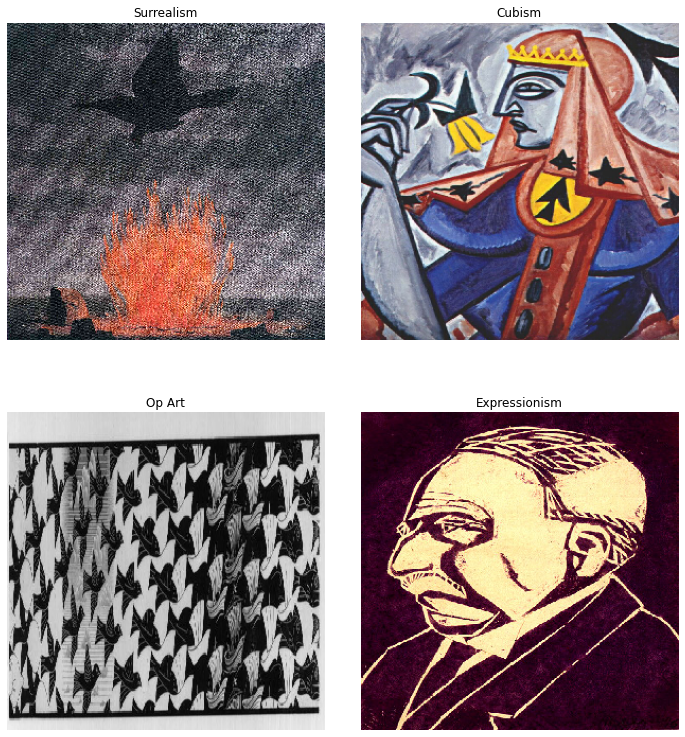

In [144]:
# Samples of dataset

fig = plt.figure(figsize=(13,13))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(2,2),
                 axes_pad=(.5,1),  # pad between axes in inch.
                 )

for (i, row), ax in zip(art_df.sample(n=4).iterrows(), grid):
    image = tf.keras.utils.load_img(row['image_file_path'], target_size=(300,300))
    ax.set_title(row['style'])
    ax.imshow(image)
    ax.axis('off')
plt.axis('off')
plt.show()

# Create symbolic links

Creating a supervised training set to train Tensorflow models is easiest when images are group in class name subdirectories.

The original images are nested under artists names and years produced. Ideally, each image would be copied into a new directory structure. This can be resource expensive and time consumer.

Instead, training sets can be created using symbolic links to the original files. The following will create a working directory structure with symbolic links to the original image.

**Unless there is a change in the data, one execution is all that is necessary.**

In [ ]:
# Preprocessing: Create directory structure with symbolic links
#
# list ( class_name, file_path)
file_class = list(art_df.itertuples(index=False, name=None))
# print(file_class[:5])

for (class_name, image_file_path) in file_class:    
    # image file name
    basename = os.path.basename(image_file_path)
    
    # Under the working directory, make a subdirectory of the class name
    os.makedirs(os.path.join(working_path, class_name), mode=511, exist_ok=True)
    
    # create a symlink to the original file in the class name subdirectory
    # os.symlink(src, dst, target_is_directory=False, *, dir_fd=None)
    try:
        os.symlink(
            os.path.join(image_file_path), 
            os.path.join(working_path, class_name, basename),
        )
    except FileExistsError:
        print("'", class_name,"' symlink file already exists")

# Create training dataset from symlinked directory structure

In [7]:
# pixels = 512 # model: efficientnet_v2_imagenet21k_xl
pixels = 224 # model: mobilenet_v3_large_100_224
IMAGE_SIZE = (pixels, pixels)
BATCH_SIZE = 16
do_data_augmentation = True #@param {type:"boolean"}

In [8]:
# This modified code example is from tf2_image_retraining tutorial

def build_dataset(subset):
    return tf.keras.preprocessing.image_dataset_from_directory(
        working_path,
        validation_split=.20,
        subset=subset,
        label_mode="categorical",
        # Seed needs to provided when using validation_split and shuffle = True.
        # A fixed seed is used so that the validation set is stable across runs.
        seed=123,
        image_size=IMAGE_SIZE,
        batch_size=1)

train_ds = build_dataset("training")
class_names = tuple(train_ds.class_names)
train_size = train_ds.cardinality().numpy()
train_ds = train_ds.unbatch().batch(BATCH_SIZE)
train_ds = train_ds.repeat()

# TODO moves to model instead of model preprocessing.
normalization_layer = tf.keras.layers.Rescaling(1. / 255)
preprocessing_model = tf.keras.Sequential([normalization_layer])


# TODO moves to model instead of model preprocessing.
# if do_data_augmentation:
if do_data_augmentation:
    print("do preprocessing")
    # TODO for "random" functions on M1 use CPU instead
    with tf.device("cpu"):
        preprocessing_model.add(tf.keras.layers.RandomRotation(40))
        preprocessing_model.add(tf.keras.layers.RandomTranslation(0, 0.2))
        preprocessing_model.add(tf.keras.layers.RandomTranslation(0.2, 0))
        # Like the old tf.keras.preprocessing.image.ImageDataGenerator(),
        # image sizes are fixed when reading, and then a random zoom is applied.
        # If all training inputs are larger than image_size, one could also use
        # RandomCrop with a batch size of 1 and rebatch later.
        preprocessing_model.add(tf.keras.layers.RandomZoom(0.2, 0.2))
        preprocessing_model.add(tf.keras.layers.RandomFlip(mode="horizontal"))
    
train_ds = train_ds.map(lambda images, labels: (preprocessing_model(images), labels))

val_ds = build_dataset("validation")
valid_size = val_ds.cardinality().numpy()
val_ds = val_ds.unbatch().batch(BATCH_SIZE)
val_ds = val_ds.map(lambda images, labels: (normalization_layer(images), labels))

Found 2791 files belonging to 10 classes.
Using 2233 files for training.
Metal device set to: Apple M1
do preprocessing
Found 2791 files belonging to 10 classes.
Using 558 files for validation.


# Cache and Prefetch data

Loads data from disk and caches in memory.

In [14]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(300).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Define the Model

In [15]:
with tf.device("cpu"):
    data_augmentation = keras.Sequential(
      [
        layers.RandomFlip("horizontal", input_shape=(pixels,pixels,3)),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
      ]
)

# Softmax vs Sigmoid Activation

Softmax output will sum to 1. The higher one number is, the more confident the prediction. If the probablilites are have more distribution amoung the classes, then the model is haveing a hard time determining the most accurate class. This can be said for any novice classifing art as well.

Sigmoid output is probablity that many classes could accurately describe data. But is art, style classifiation generally leans towards a single class, and even multiple influences can be see in particular work.

For classifying art style, either activation method in the final layer could be justified. For the purposes of this art style classifier, softmax best relects the intent of the classification method. Generally, one style dominates but a mixture of many classes is possible.

In [16]:
# model_handle = 'https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_xl/feature_vector/2'
model_handle = 'https://tfhub.dev/google/imagenet/mobilenet_v3_large_100_224/feature_vector/5'
do_fine_tuning = False

print("Building model with", model_handle)
model = tf.keras.Sequential([

    tf.keras.layers.InputLayer(input_shape=IMAGE_SIZE + (3,)),
    # data_augmentation,
    
    # load pretrained model
    hub.KerasLayer(model_handle, trainable=do_fine_tuning),
    
    tf.keras.layers.Dropout(rate=0.1),
    tf.keras.layers.Dense(len(class_names),
                          kernel_regularizer=tf.keras.regularizers.l2(0.0001),
                          activation = 'softmax' 
                         )
])
model.build((None,)+IMAGE_SIZE+(3,))
model.summary()

Building model with https://tfhub.dev/google/imagenet/mobilenet_v3_large_100_224/feature_vector/5
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              4226432   
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                12810     
Total params: 4,239,242
Trainable params: 12,810
Non-trainable params: 4,226,432
_________________________________________________________________


# Training Model

In [34]:
model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.005, momentum=0.9),
    loss=tf.keras.losses.CategoricalCrossentropy(
      # from_logits=True, 
      from_logits=False, 
      label_smoothing=0.1
    ),
  metrics=['accuracy'])

In [35]:
steps_per_epoch = train_size // BATCH_SIZE
validation_steps = valid_size // BATCH_SIZE
hist = model.fit(
    train_ds,
    epochs=10,
    verbose=1,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_ds,
    validation_steps=validation_steps).history

model.save("./art-classification-multi-class-mobilenet-v3-large-sigmoid-0.1dropout-softmax")


Epoch 1/10
139/139 [==============================] - 52s 138ms/step - loss: 1.7463 - accuracy: 0.4547 - val_loss: 1.6572 - val_accuracy: 0.5129
Epoch 2/10
139/139 [==============================] - 17s 125ms/step - loss: 1.4743 - accuracy: 0.5886 - val_loss: 1.5725 - val_accuracy: 0.5515
Epoch 3/10
139/139 [==============================] - 17s 124ms/step - loss: 1.3783 - accuracy: 0.6138 - val_loss: 1.5963 - val_accuracy: 0.5699
Epoch 4/10
139/139 [==============================] - 16s 116ms/step - loss: 1.3735 - accuracy: 0.6151 - val_loss: 1.5669 - val_accuracy: 0.5643
Epoch 5/10
139/139 [==============================] - 16s 113ms/step - loss: 1.3165 - accuracy: 0.6437 - val_loss: 1.5371 - val_accuracy: 0.5827
Epoch 6/10
139/139 [==============================] - 17s 121ms/step - loss: 1.3041 - accuracy: 0.6495 - val_loss: 1.4791 - val_accuracy: 0.6011
Epoch 7/10
139/139 [==============================] - 15s 111ms/step - loss: 1.2766 - accuracy: 0.6718 - val_loss: 1.6024 - val_ac

INFO:tensorflow:Assets written to: ./art-classification-multi-class-mobilenet-v3-large-sigmoid-0.1dropout-softmax/assets


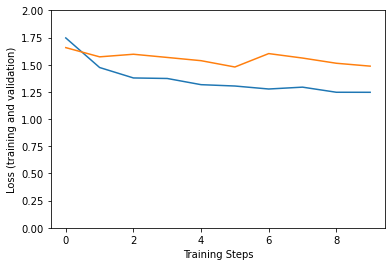

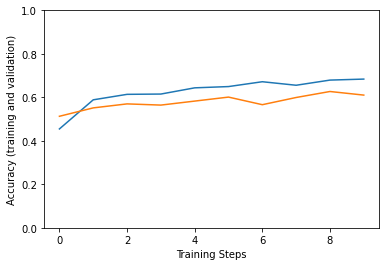

In [36]:
plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])

plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(hist["accuracy"])
plt.plot(hist["val_accuracy"])

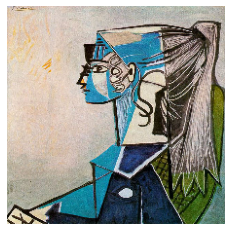

[('Abstract Art', 0.00072525034), ('Abstract Expressionism', 0.00076223625), ('Cubism', 0.062577575), ('Expressionism', 0.01450981), ('Naïve Art (Primitivism)', 0.00040359693), ('Op Art', 0.0005664235), ('Pop Art', 0.0010298738), ('Street art', 0.002163691), ('Suprematism', 0.004480474), ('Surrealism', 0.9127811)]
True label: Cubism
Predicted label: Surrealism


In [25]:
x, y = next(iter(val_ds))

image = x[0, :, :, :]
true_index = np.argmax(y[0])
plt.imshow(image)
plt.axis('off')
plt.show()
# Expand the validation image to (1, 224, 224, 3) before predicting the label
prediction_scores = model.predict(np.expand_dims(image, axis=0))
print(list(zip(class_names, prediction_scores[0])))


predicted_index = np.argmax(prediction_scores)
print("True label: " + class_names[true_index])
print("Predicted label: " + class_names[predicted_index])

In [16]:
reloaded_model = tf.keras.models.load_model("/Users/tod/todgru/notes/pdev/art-classifier-ml-deploy/art-classifier-model/art-classification-multi-class-mobilenet-v3-large-sigmoid-0.1dropout-softmax")
# Check its architecture
reloaded_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_3 (KerasLayer)  (None, 1280)              4226432   
                                                                 
 dropout_3 (Dropout)         (None, 1280)              0         
                                                                 
 dense_3 (Dense)             (None, 10)                12810     
                                                                 
Total params: 4,239,242
Trainable params: 12,810
Non-trainable params: 4,226,432
_________________________________________________________________


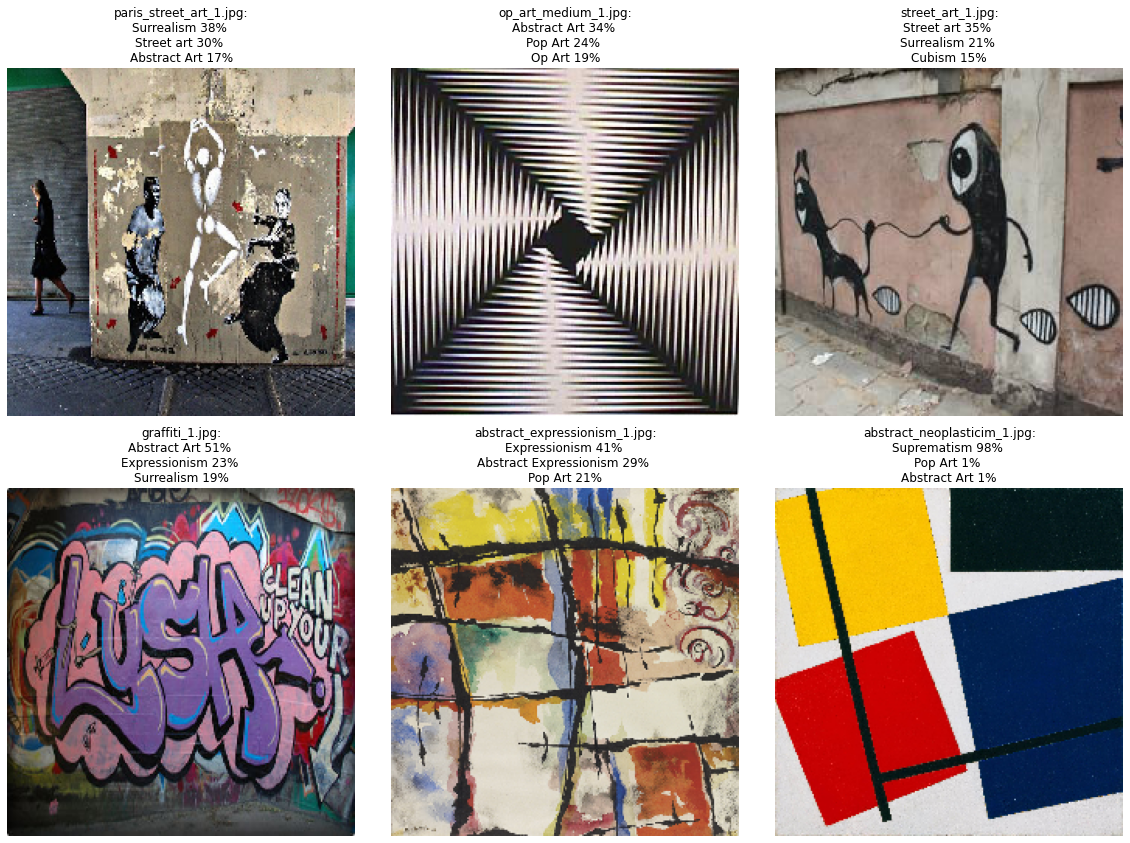

In [71]:
from mpl_toolkits.axes_grid1 import ImageGrid

test_image_urls = [
    ("paris_street_art_1.jpg", "http://www.missionmission.org/wp-content/uploads/2009/03/paris-street-art.jpg"),
    ("op_art_medium_1.jpg", "http://www.biddingtons.com/os/item_images/100005_egrichardallen.jpg"),
    ("street_art_1.jpg", "https://s.inyourpocket.com/gallery/148449m.jpg"),
    ("graffiti_1.jpg", "https://s3.amazonaws.com/content.fatcap.com/opct_7be7040d3181da960d43eabeaf031b8b8ff35e67.jpg"),
#     ("abstract_expressionism_2", "https://uploads3.wikiart.org/images/kazuo-nakamura/inner-view-3-1955.jpg!Large.jpg"),
#     ("graffiti_3.jpg", "https://www.logolynx.com/images/logolynx/a6/a6c396af9888ffba089b6ef4ae18e4c6.jpeg"),
    ("abstract_expressionism_1.jpg", "https://uploads2.wikiart.org/images/jock-macdonald/from-a-riviera-window-1955.jpg"),
    ("abstract_neoplasticim_1.jpg", "https://uploads7.wikiart.org/images/theo-van-doesburg/simultaneous-counter-composition-1930.jpg")
    
]

images_to_display = []
image_predictions= []
image_titles= []
model = reloaded_model


def load_image_array(tup):
    name, url = tup
    image_path = tf.keras.utils.get_file(name, origin=url)
    img = tf.keras.utils.load_img(image_path, target_size=(pixels, pixels))
    images_to_display.append(img)
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    img_array = img_array / 255
    
    return img_array

def get_predictions(img_array):
    [rank] = model.predict(img_array)
    preds = zip(list(class_names), list(rank))
    score = list(sorted(list(preds), key = lambda z: z[1], reverse = True)[:len(class_names)])

    return score


def format_predictions(score):
    first = score[0]
    second = score[1]
    third = score[2]
    return """
{} {:.0f}% 
{} {:.0f}% 
{} {:.0f}%""".format(
        first[0], 100 * first[1], 
        second[0],100*second[1], 
        third[0],100*third[1])


for tup in test_image_urls:
    img_array = load_image_array(tup)
    score = get_predictions(img_array)
    image_predictions.append(score)
    image_titles.append(format_predictions(score))
    
n_row = int(len(test_image_urls))
n_col = 2


fig = plt.figure(figsize=(20,20))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(2,3),
                 axes_pad=(.5,1),  # pad between axes in inch.
                 )

# print(class_names)
for p, url, img, ax in zip(image_titles, test_image_urls, images_to_display, grid):
    if (img == None):
        continue
    ax.set_title("{}:{}".format(url[0],p))
    ax.imshow(img)
    ax.axis('off')
plt.axis('off')
plt.show()

    